In [21]:
import os
import glob
import numpy as np
import rasterio

# Path to your GPP rasters folder
data_folder = os.path.join("..","data","Datasets_Hackathon","MODIS_Gross_Primary_Production_GPP")

# Collect all GeoTIFF files and sort them (e.g. by year or another date indicator)
tif_files = sorted(glob.glob(os.path.join(data_folder, "*.tif")))

# Create an output folder for the difference rasters
output_folder = os.path.join(data_folder, "gpp_differences")
os.makedirs(output_folder, exist_ok=True)

if len(tif_files) < 2:
    raise ValueError("Need at least two GPP files to compute differences.")

for i in range(len(tif_files) - 1):
    file1 = tif_files[i]     # e.g., file from year1 or date1
    file2 = tif_files[i + 1] # e.g., file from year2 or date2

    # Open the first file
    with rasterio.open(file1) as src1:
        data1 = src1.read(1).astype(np.float32)
        profile = src1.profile.copy()
        nodata1 = src1.nodata

    # Open the second file
    with rasterio.open(file2) as src2:
        data2 = src2.read(1).astype(np.float32)
        nodata2 = src2.nodata

    # Create masks for nodata values if defined
    mask1 = (data1 == nodata1) if nodata1 is not None else np.zeros(data1.shape, dtype=bool)
    mask2 = (data2 == nodata2) if nodata2 is not None else np.zeros(data2.shape, dtype=bool)
    valid_mask = ~mask1 & ~mask2

    # Initialize difference array with a nodata value, e.g. -9999
    diff_array = np.full_like(data1, fill_value=-9999, dtype=np.float32)

    # Compute the difference where both rasters have valid data (e.g., file2 - file1)
    diff_array[valid_mask] = data2[valid_mask] - data1[valid_mask]

    # Update the profile for the output raster
    profile.update({
        'dtype': 'float32',
        'count': 1,
        'nodata': -9999,
        'compress': 'lzw'   # Optional: adds LZW compression
    })

    # Build output filename, e.g., "gpp_diff_2018_to_2019.tif"
    base1 = os.path.splitext(os.path.basename(file1))[0]
    base2 = os.path.splitext(os.path.basename(file2))[0]
    out_name = f"gpp_diff_{base1}_to_{base2}.tif"
    out_path = os.path.join(output_folder, out_name)

    # Write out the difference raster
    with rasterio.open(out_path, 'w', **profile) as dst:
        dst.write(diff_array, 1)

    print(f"Created difference raster: {out_path}")


Created difference raster: ..\data\Datasets_Hackathon\MODIS_Gross_Primary_Production_GPP\gpp_differences\gpp_diff_2010_GP_to_2011_GP.tif
Created difference raster: ..\data\Datasets_Hackathon\MODIS_Gross_Primary_Production_GPP\gpp_differences\gpp_diff_2011_GP_to_2012_GP.tif
Created difference raster: ..\data\Datasets_Hackathon\MODIS_Gross_Primary_Production_GPP\gpp_differences\gpp_diff_2012_GP_to_2013_GP.tif
Created difference raster: ..\data\Datasets_Hackathon\MODIS_Gross_Primary_Production_GPP\gpp_differences\gpp_diff_2013_GP_to_2014_GP.tif
Created difference raster: ..\data\Datasets_Hackathon\MODIS_Gross_Primary_Production_GPP\gpp_differences\gpp_diff_2014_GP_to_2015_GP.tif
Created difference raster: ..\data\Datasets_Hackathon\MODIS_Gross_Primary_Production_GPP\gpp_differences\gpp_diff_2015_GP_to_2016_GP.tif
Created difference raster: ..\data\Datasets_Hackathon\MODIS_Gross_Primary_Production_GPP\gpp_differences\gpp_diff_2016_GP_to_2017_GP.tif
Created difference raster: ..\data\Datase

In [4]:
import matplotlib.colors as colors

# Creiamo un colormap lineare: [rosso -> bianco -> verde]
rwg_cmap = colors.LinearSegmentedColormap.from_list(
    'rwg',  # nome che vogliamo dare al colormap
    [(1.0, 0.0, 0.0),  # rosso puro
     (1.0, 1.0, 1.0),  # bianco
     (0.0, 1.0, 0.0)]  # verde puro
)


In [6]:
import numpy as np

# Supponiamo di avere un array 'diff_data' con i delta di precipitazione
# Troviamo il valore assoluto massimo (in modo da usare una scala simmetrica)
max_abs = np.max(np.abs(diff_data))

# Definiamo un norm centrato su 0
norm = colors.TwoSlopeNorm(vmin=-max_abs, vcenter=0, vmax=max_abs)


In [9]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import matplotlib.colors as colors

# Colormap personalizzato: [rosso, bianco, verde]
rwg_cmap = colors.LinearSegmentedColormap.from_list(
    'rwg',
    [(1.0, 0.0, 0.0),   # rosso
     (1.0, 1.0, 1.0),   # bianco
     (0.0, 1.0, 0.0)]   # verde
)

# Cartella con i GeoTIFF delle differenze
diff_folder = "../Datasets_Hackathon/Climate_Precipitation_Data/precip_differences"
diff_files = sorted(glob.glob(os.path.join(diff_folder, "*.tif")))

if not diff_files:
    raise FileNotFoundError("Nessun file di differenza trovato nella cartella 'precip_differences'.")

# Creiamo una cartella per salvare i plot
output_plots_folder = os.path.join(diff_folder, "plots_rwg")
os.makedirs(output_plots_folder, exist_ok=True)

for diff_tif in diff_files:
    with rasterio.open(diff_tif) as ds:
        diff_data = ds.read(1).astype(float)
        nodata_val = ds.nodata

    # Mascheriamo i nodata
    diff_data = np.ma.masked_equal(diff_data, nodata_val)

    # Calcoliamo il massimo valore assoluto per questo raster
    max_abs = np.max(np.abs(diff_data))

    # Creiamo un norm centrato su zero
    norm = colors.TwoSlopeNorm(vmin=-max_abs, vcenter=0, vmax=max_abs)

    # Visualizzazione
    plt.figure(figsize=(8, 6))
    im = plt.imshow(diff_data, cmap=rwg_cmap, norm=norm)
    plt.colorbar(im, label="Delta precipitazione (mm) [Year+1 - Year]")
    plt.title(f"Diff: {os.path.basename(diff_tif)}")
    plt.axis("off")

    # Salviamo il plot come PNG (con lo stesso nome base del TIFF)
    out_png_name = os.path.splitext(os.path.basename(diff_tif))[0] + ".png"
    out_png_path = os.path.join(output_plots_folder, out_png_name)
    plt.savefig(out_png_path, dpi=300, bbox_inches="tight")
    plt.close()

    print(f"Salvato il plot: {out_png_path}")


Salvato il plot: ../Datasets_Hackathon/Climate_Precipitation_Data/precip_differences\plots_rwg\precip_diff_2010R_to_2011R.png
Salvato il plot: ../Datasets_Hackathon/Climate_Precipitation_Data/precip_differences\plots_rwg\precip_diff_2011R_to_2012R.png
Salvato il plot: ../Datasets_Hackathon/Climate_Precipitation_Data/precip_differences\plots_rwg\precip_diff_2012R_to_2013R.png
Salvato il plot: ../Datasets_Hackathon/Climate_Precipitation_Data/precip_differences\plots_rwg\precip_diff_2013R_to_2014R.png
Salvato il plot: ../Datasets_Hackathon/Climate_Precipitation_Data/precip_differences\plots_rwg\precip_diff_2014R_to_2015R.png
Salvato il plot: ../Datasets_Hackathon/Climate_Precipitation_Data/precip_differences\plots_rwg\precip_diff_2015R_to_2016R.png
Salvato il plot: ../Datasets_Hackathon/Climate_Precipitation_Data/precip_differences\plots_rwg\precip_diff_2016R_to_2017R.png
Salvato il plot: ../Datasets_Hackathon/Climate_Precipitation_Data/precip_differences\plots_rwg\precip_diff_2017R_to_20

In [8]:
# Crea cartella di output
output_plot_folder = os.path.join(diff_folder, "plots_rwg")
os.makedirs(output_plot_folder, exist_ok=True)

out_png = os.path.splitext(os.path.basename(diff_tif))[0] + ".png"
out_path = os.path.join(output_plot_folder, out_png)

plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.close()
print(f"Salvato: {out_path}")


Salvato: ../Datasets_Hackathon/Climate_Precipitation_Data/precip_differences\plots_rwg\precip_diff_2022R_to_2023R.png


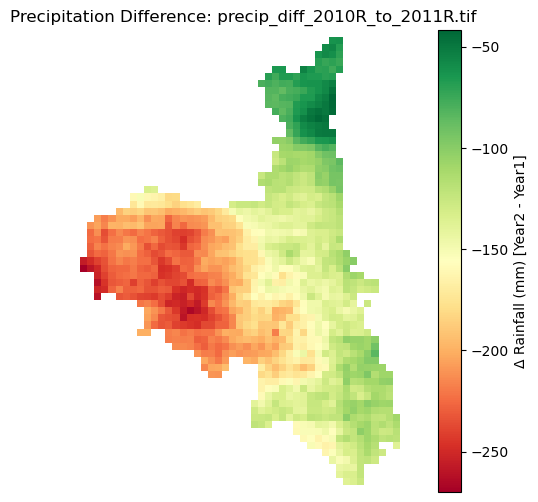

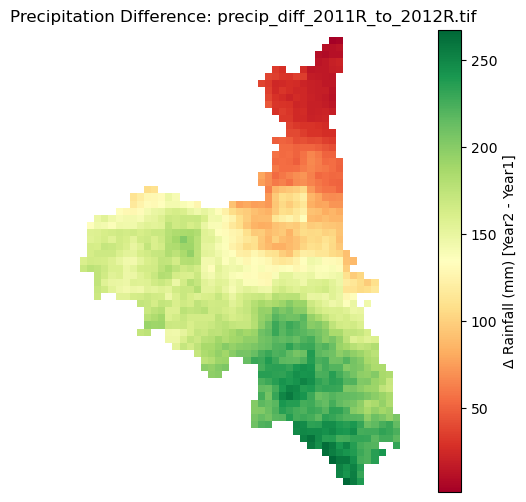

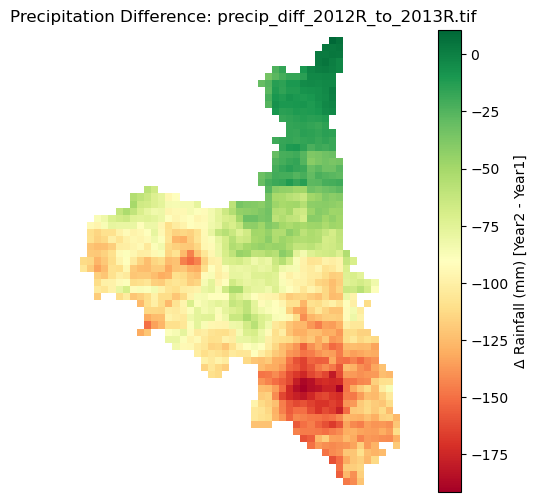

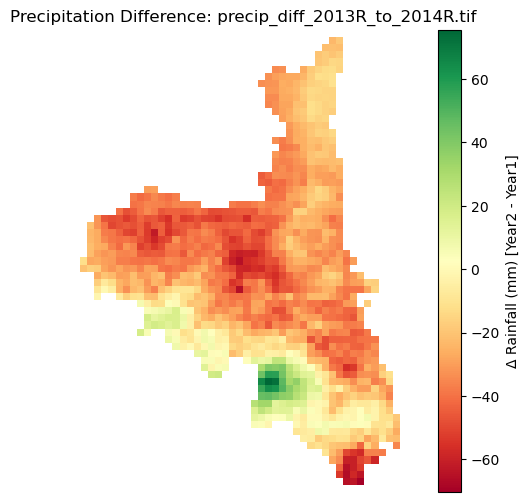

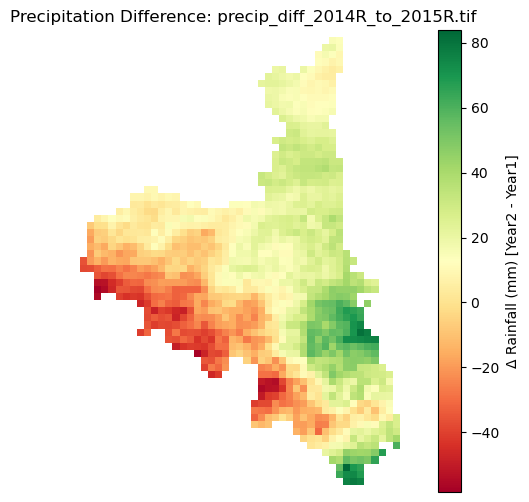

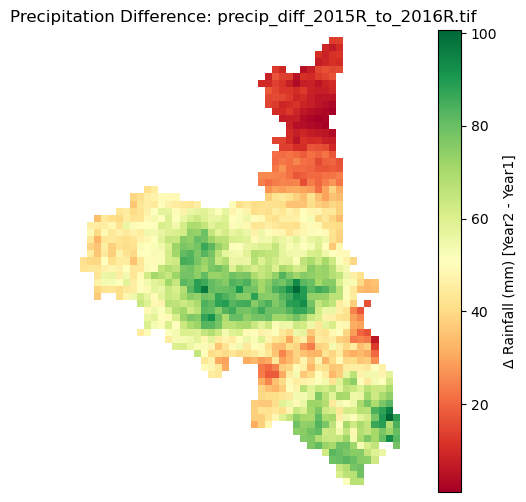

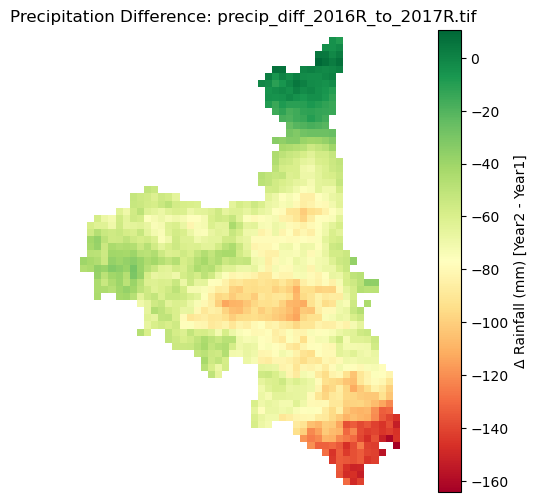

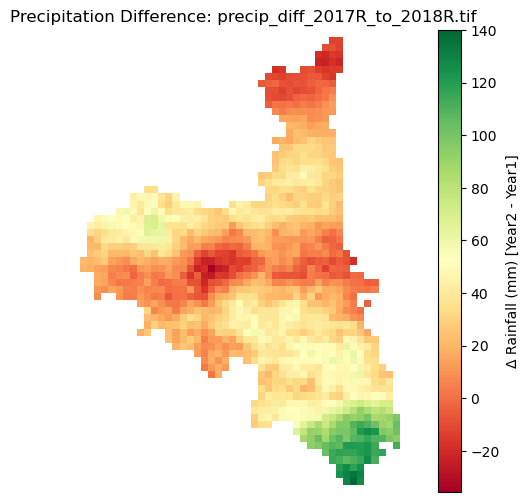

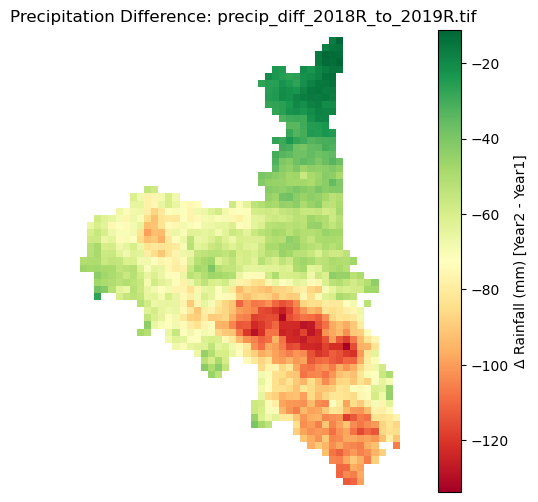

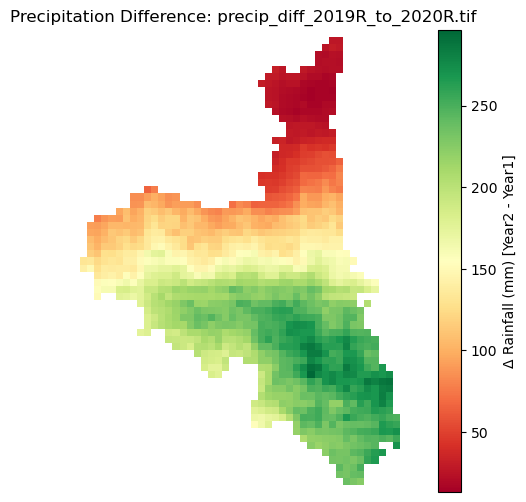

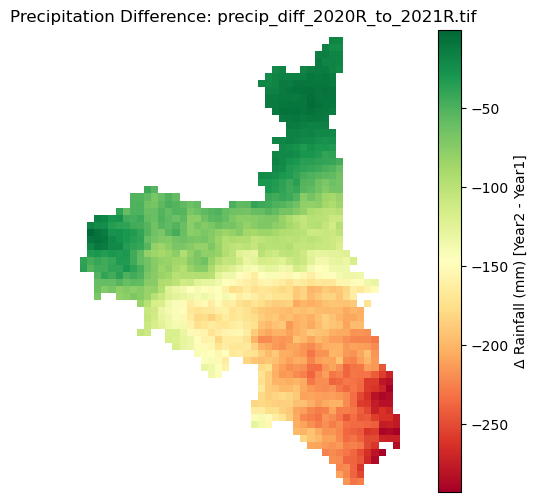

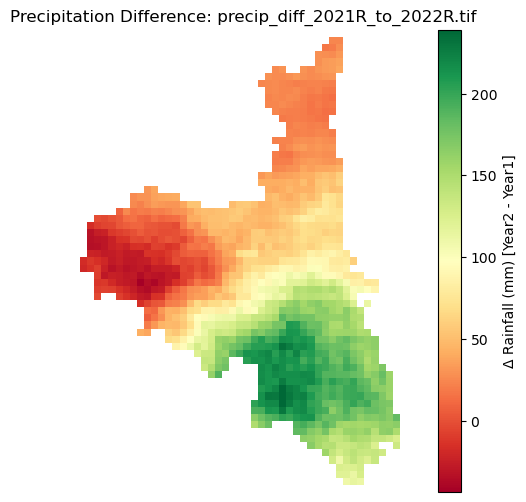

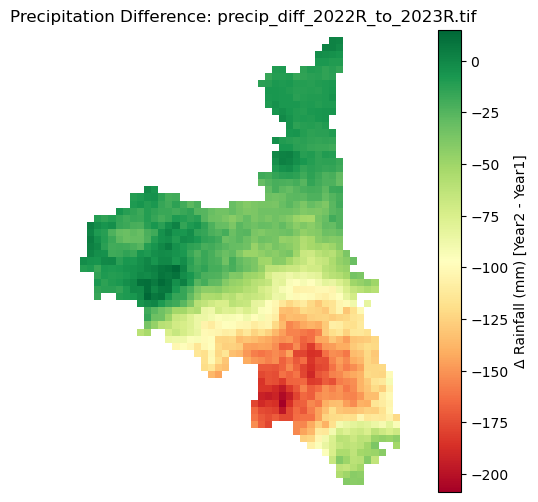

In [2]:
import os
import glob
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Where we saved the difference TIFFs
diff_folder = "../Datasets_Hackathon/Climate_Precipitation_Data/precip_differences"
diff_files = sorted(glob.glob(os.path.join(diff_folder, "*.tif")))

if not diff_files:
    raise FileNotFoundError("No difference rasters found in the 'precip_differences' folder.")

for diff_tif in diff_files:
    with rasterio.open(diff_tif) as ds:
        diff_data = ds.read(1)
        nodata_val = ds.nodata

    # Mask out the nodata
    diff_data = np.ma.masked_equal(diff_data, nodata_val)

    # Plot
    plt.figure(figsize=(8, 6))
    # 'RdYlGn' => Red for negative, Green for positive
    im = plt.imshow(diff_data, cmap='RdYlGn')
    plt.colorbar(im, label="Δ Rainfall (mm) [Year2 - Year1]")
    plt.title(f"Precipitation Difference: {os.path.basename(diff_tif)}")
    plt.axis("off")
    plt.show()


In [3]:
# ...
output_plot_folder = os.path.join(diff_folder, "plots")
os.makedirs(output_plot_folder, exist_ok=True)

for diff_tif in diff_files:
    with rasterio.open(diff_tif) as ds:
        diff_data = ds.read(1)
        nodata_val = ds.nodata
    diff_data = np.ma.masked_equal(diff_data, nodata_val)

    plt.figure(figsize=(8, 6))
    plt.imshow(diff_data, cmap='RdYlGn')
    plt.colorbar(label="Δ Rainfall (mm) [Year2 - Year1]")
    plt.title(f"Precipitation Difference: {os.path.basename(diff_tif)}")
    plt.axis("off")

    # Save the figure
    out_plot_name = os.path.basename(diff_tif).replace(".tif", ".png")
    out_plot_path = os.path.join(output_plot_folder, out_plot_name)
    plt.savefig(out_plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved plot: {out_plot_path}")


Saved plot: ../Datasets_Hackathon/Climate_Precipitation_Data/precip_differences\plots\precip_diff_2010R_to_2011R.png
Saved plot: ../Datasets_Hackathon/Climate_Precipitation_Data/precip_differences\plots\precip_diff_2011R_to_2012R.png
Saved plot: ../Datasets_Hackathon/Climate_Precipitation_Data/precip_differences\plots\precip_diff_2012R_to_2013R.png
Saved plot: ../Datasets_Hackathon/Climate_Precipitation_Data/precip_differences\plots\precip_diff_2013R_to_2014R.png
Saved plot: ../Datasets_Hackathon/Climate_Precipitation_Data/precip_differences\plots\precip_diff_2014R_to_2015R.png
Saved plot: ../Datasets_Hackathon/Climate_Precipitation_Data/precip_differences\plots\precip_diff_2015R_to_2016R.png
Saved plot: ../Datasets_Hackathon/Climate_Precipitation_Data/precip_differences\plots\precip_diff_2016R_to_2017R.png
Saved plot: ../Datasets_Hackathon/Climate_Precipitation_Data/precip_differences\plots\precip_diff_2017R_to_2018R.png
Saved plot: ../Datasets_Hackathon/Climate_Precipitation_Data/pre